# International Air Passenger Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Import data and basic analysis

In [2]:
air_passengers = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], infer_datetime_format=True,
                             names = ['Month', 'Passengers'], index_col = 0)


In [3]:
air_passengers.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
min(air_passengers.index)

Timestamp('1949-01-01 00:00:00')

In [5]:
max(air_passengers.index)

Timestamp('1960-12-01 00:00:00')

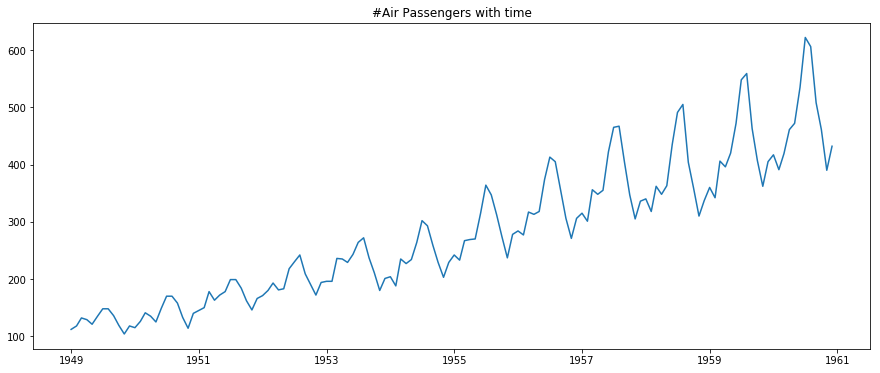

In [6]:
plt.plot(air_passengers)
plt.title('#Air Passengers with time')
plt.savefig('plots/ap_data_plot.jpg')


# the plot clearly shows increase in variance of #passengers 
# with time, so lets take the log of the data to 
# penalize the higher magnitude values.

In [7]:
log_air_passengers = np.log(air_passengers)

In [8]:
log_air_passengers.head()

,Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


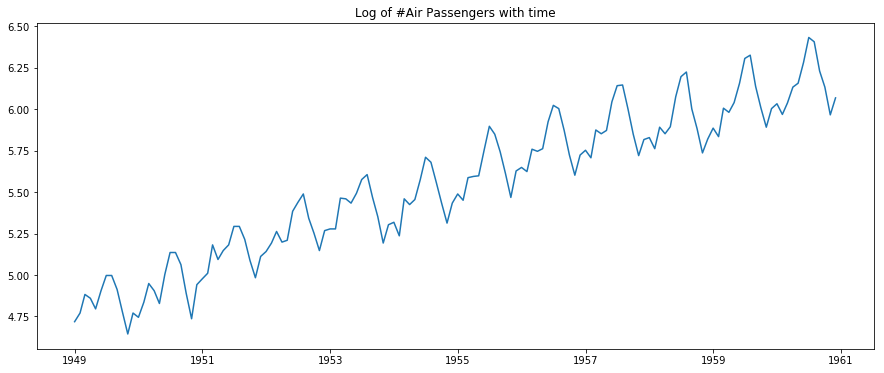

In [9]:
plt.plot(log_air_passengers)
plt.title('Log of #Air Passengers with time')
plt.savefig('plots/ap_log_data_plot.jpg')

# we can now clearly see there is a upward trend
# and some seasonality effect

In [10]:
# lets difference the data with lag-1 so check for stationarity
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift()

In [11]:
# lets difference the data with lag-1 so check for stationarity
log_air_passengers_diff2 = log_air_passengers - log_air_passengers.shift(2)

In [12]:
log_air_passengers_diff2.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,0.164303
1949-04-01,0.089128
1949-05-01,-0.087011


            Passengers
Month                 
1949-03-01    0.164303
1949-04-01    0.089128
1949-05-01   -0.087011
1949-06-01    0.045462
1949-07-01    0.201422


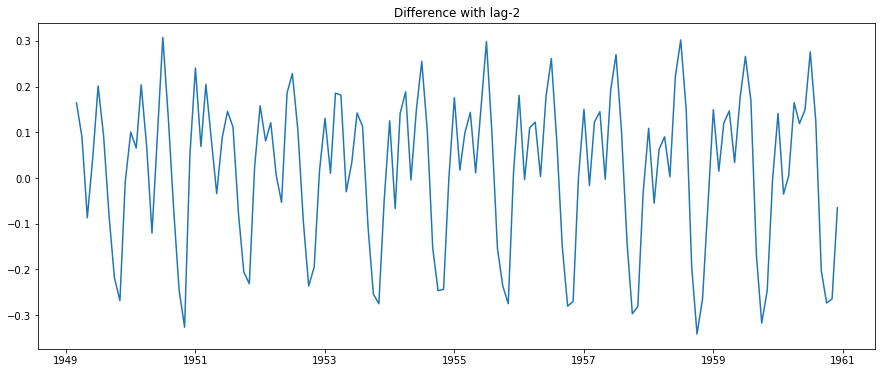

In [13]:
# drop the NaN value
log_air_passengers_diff2.dropna(inplace=True)
print(log_air_passengers_diff2.head())

# now lets see if the data is stationary or not.
plt.plot(log_air_passengers_diff2)
plt.title('Difference with lag-2')
plt.savefig('plots/ap_diff2.jpg')

In [14]:
# the first value will be NaN as we have shifted the data.
log_air_passengers_diff.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022


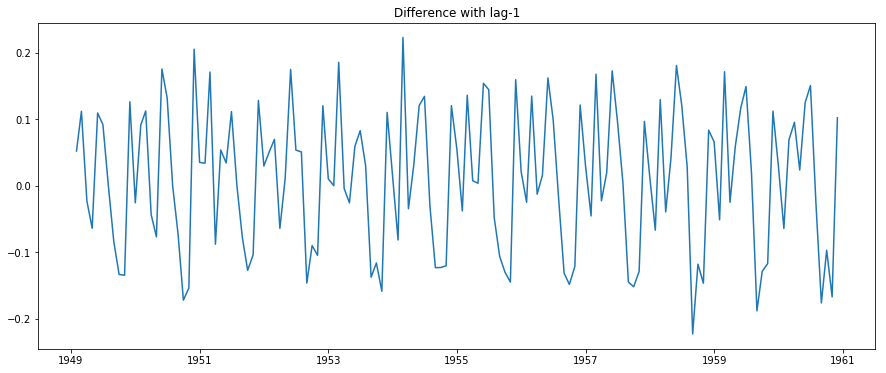

In [15]:
# now lets see if the data is stationary or not.
plt.plot(log_air_passengers_diff)
plt.title('Difference with lag-1')
plt.savefig('plots/ap_diff1.jpg')

In [16]:
# drop the NaN value
log_air_passengers_diff.dropna(inplace=True)

In [17]:
log_air_passengers_diff.head()

,Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484


In [18]:
log_air_passengers_diff.tail()

,Passengers
Month,
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083
1960-11-01,-0.167251
1960-12-01,0.102279


## Check stationarity of the data using Dickey-Fuller test

In [19]:
import pandas.tseries
from statsmodels.tsa.stattools import adfuller

In [20]:
# adfuller method works for 1d data so, the data should 
# either be a series or a 1d numpy array

# write a funtion to check the stationarity of the data.
def check_data_stationarity(data):
    
    fuller_results = adfuller(data['Passengers'])

    print('Fuller Statistics : {}'.format(fuller_results[0]))
    print('Fuller test P-value : {}'.format(fuller_results[1]))
    print('#lags used : {}'.format(fuller_results[2]))
    print('#observation used: {}'.format(fuller_results[3]))

    for key, value in fuller_results[4].items():
        print('Significance Level and value: {0}, : {1}:'.format(key, value))
        
    return

In [21]:
# check log data for stationarity
check_data_stationarity(log_air_passengers)

# the p-value is greater than critical value so
# we cannot reject the null hypothesis

# H0 - the series is not stationary
# H1 - the series is stationary

Fuller Statistics : -1.7170170891069714
Fuller test P-value : 0.4223667747703857
#lags used : 13
#observation used: 130
Significance Level and value: 1%, : -3.4816817173418295:
Significance Level and value: 5%, : -2.8840418343195267:
Significance Level and value: 10%, : -2.578770059171598:


In [22]:
# check log differenced data for stationarity

# the p-value is greater than critical value so
# we cannot reject the null hypothesis

# H0 - the series is not stationary
# H1 - the series is stationary

check_data_stationarity(log_air_passengers_diff)

Fuller Statistics : -2.717130598388145
Fuller test P-value : 0.0711205481508568
#lags used : 14
#observation used: 128
Significance Level and value: 1%, : -3.4825006939887997:
Significance Level and value: 5%, : -2.884397984161377:
Significance Level and value: 10%, : -2.578960197753906:


In [23]:
# check log differenced - 2 data for stationarity

# the p-value is greater than critical value so
# we cannot reject the null hypothesis

# H0 - the series is not stationary
# H1 - the series is stationary

check_data_stationarity(log_air_passengers_diff2)

Fuller Statistics : -3.1679073752887454
Fuller test P-value : 0.021919114564038708
#lags used : 11
#observation used: 130
Significance Level and value: 1%, : -3.4816817173418295:
Significance Level and value: 5%, : -2.8840418343195267:
Significance Level and value: 10%, : -2.578770059171598:


In [24]:
from statsmodels.tsa.stattools import acf, pacf

In [25]:
# lets look at the acf and pacf plots of log data
lag_acf = acf(log_air_passengers.values, nlags = 30)
lag_pacf = pacf(log_air_passengers.values, nlags = 30)

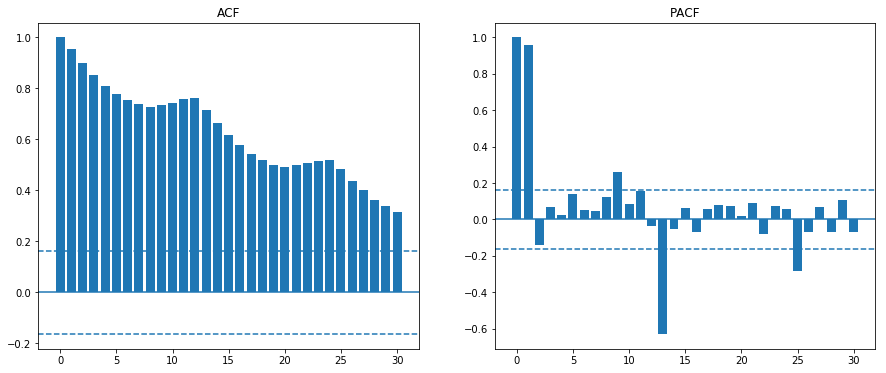

In [26]:
## for log transformed data..

# Auto-Correlation Function to check MA process 
plt.subplot(121) 
plt.bar(range(len(lag_acf)), height = lag_acf)
plt.axhline(y=0, linestyle='-')
plt.title('ACF')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers)), linestyle='--')

# look at where the plot crosses the upper confidence interval for the first time
# for ACF this is 1 and gives us the p value

# Partial Auto-Correlation Function to check AR process
plt.subplot(122) 
plt.bar(range(len(lag_pacf)), height = lag_pacf)
plt.axhline(y=0, linestyle='-')
plt.title('PACF')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers)), linestyle='--')

plt.savefig('plots/ap_acf_pacf_log_data.jpg')
# look at where the plot crosses the upper confidence interval for the first time
# for PACF this is 2 and gives us the p value

### acf plot:
    # 1. definately some seasonality (yearly) for ma(q) process
    # 2. check the difference data
### pacf plot:
    # 1. lag 1 and lag 12 are significant, so, ar(1) process and sar(1)
    # 2. lag is significant for lag 8 or 9
    # 3. check the difference data

In [27]:
# diff-1 log transformed data
d_lag_acf = acf(log_air_passengers_diff.values, nlags = 30)
d_lag_pacf = pacf(log_air_passengers_diff.values, nlags = 30)

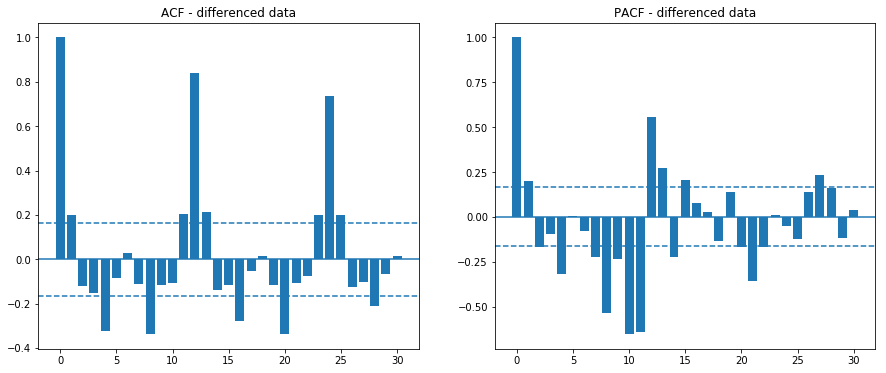

In [28]:
## for differenced log data..

# Auto-Correlation Function to check MA process 
plt.subplot(121) 
plt.bar(range(len(d_lag_acf)), height = d_lag_acf)
plt.axhline(y=0, linestyle='-')
plt.title('ACF - differenced data')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')

# Partial Auto-Correlation Function to check AR process
plt.subplot(122) 
plt.bar(range(len(d_lag_acf)), height = d_lag_pacf)
plt.axhline(y=0, linestyle='-')
plt.title('PACF - differenced data')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')

plt.savefig('plots/ap_acf_pacf_diff1.jpg')

In [29]:
# diff-2 log transformed data
d2_lag_acf = acf(log_air_passengers_diff2.values, nlags = 30)
d2_lag_pacf = pacf(log_air_passengers_diff2.values, nlags = 30)

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


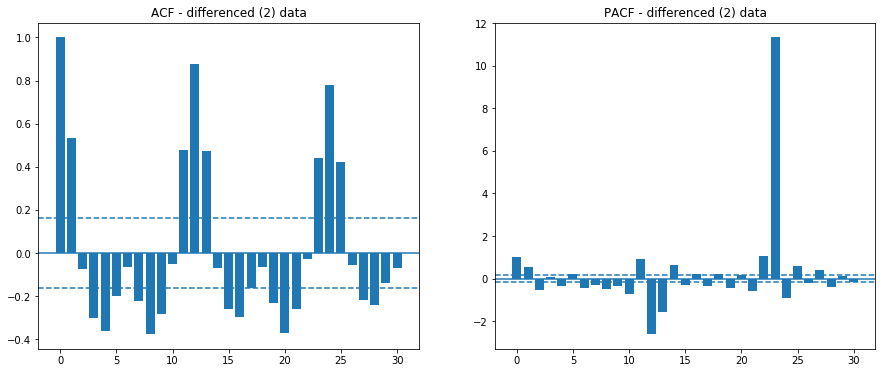

In [30]:
## for differenced 2 log data..

# Auto-Correlation Function to check MA process 
plt.subplot(121) 
plt.bar(range(len(d2_lag_acf)), height = d2_lag_acf)
plt.axhline(y=0, linestyle='-')
plt.title('ACF - differenced (2) data')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff2)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff2)), linestyle='--')

# Partial Auto-Correlation Function to check AR process
plt.subplot(122) 
plt.bar(range(len(d2_lag_acf)), height = d2_lag_pacf)
plt.axhline(y=0, linestyle='-')
plt.title('PACF - differenced (2) data')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff2)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff2)), linestyle='--')

plt.savefig('plots/ap_acf_pacf_diff2.jpg')

### acf plot:
    # 1. yearly and might be quaterly seasonality for ma(q) process
### pacf plot:
    # 1. lag 1 and lag 12 are significant, so, ar(1) process and sar(1)
    # 2. lag is significant for lag 8 or 9
    
### Observation: 
    1. It is not clear about the actual process that can be applied using
       the above details, so we will have to use some more exploration techniques.
    2. Let try to fit ARIMA models then we can check Exponential Weighted Moving Average(EWMA)

## forecasting

In [31]:
from statsmodels.tsa.arima_model import ARIMA

In [32]:
## ARIMA model

# the parameter order has 3 components :
# 1. The number of Auto-Regressive Terms (p)
# 2. The number of differences taken (d)
# 3. The number of Moving Average Terms (q)

def arima_model_fitting(raw_data, pdq = (), plotting = True, **kwargs):
    
    diff1 = raw_data - raw_data.shift()
    diff1.dropna(inplace=True)
    
    diff2 = raw_data - raw_data.shift(2)
    diff2.dropna(inplace=True)
    
    model = ARIMA(log_air_passengers, order= pdq)  
    results = model.fit(disp=-1)  

    if plotting and kwargs['D1']:
        plt.plot(diff1)
        plt.plot(results.fittedvalues, color='red')
        rss_value = sum((results.fittedvalues - diff1['Passengers'])**2)
        plt.title('Residual SSE : {} '.format(rss_value))
    
    elif plotting and kwargs['D2']:
        plt.plot(diff2)
        plt.plot(results.fittedvalues, color='red')
        rss_value = sum((results.fittedvalues - diff2['Passengers'])**2)
        plt.title('Residual SSE : {} '.format(rss_value))
    
    else:
        return results.fittedvalues

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


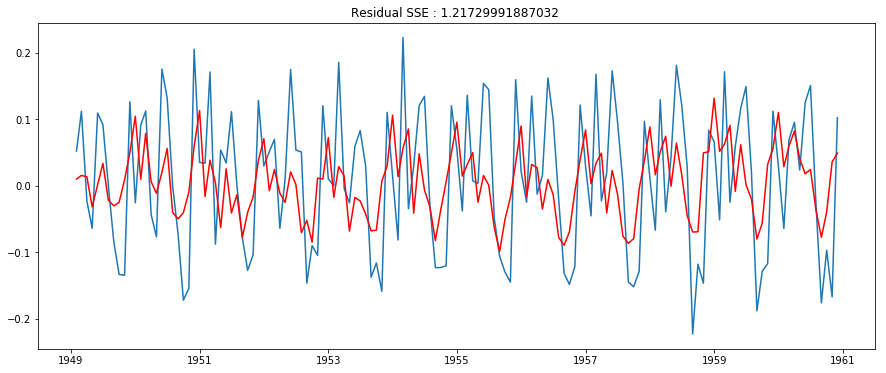

In [33]:
## AR(1) + MA(2) + 1 difference
arima_model_fitting(log_air_passengers, pdq = (1, 1, 2), **{'D1': True})

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


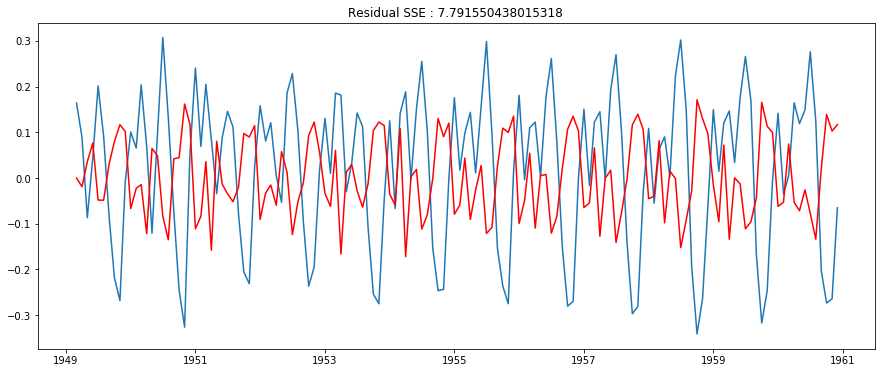

In [34]:
## AR(2) + MA(2) + 2 difference
diff_kwargs = {'1': False, '2': True}
arima_model_fitting(log_air_passengers, pdq = (2, 2, 2), **{'D1': False, 'D2': True})

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


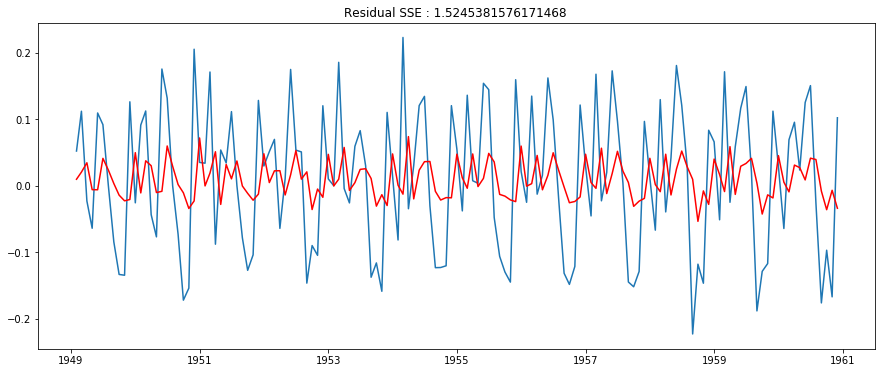

In [35]:
## AR(0) + MA(1) + 1 difference
arima_model_fitting(log_air_passengers, pdq = (0, 1, 1), **{'D1': True, 'D2': False})

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


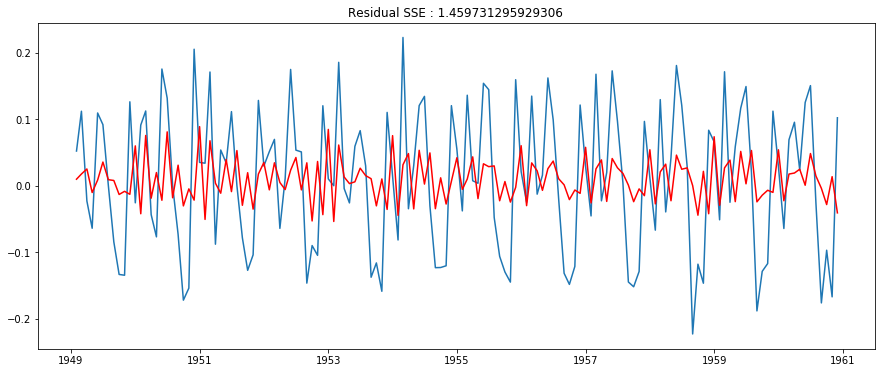

In [36]:
## AR(1) + MA(1) + 1 difference
arima_model_fitting(log_air_passengers, pdq = (1, 1, 1), **{'D1': True})

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


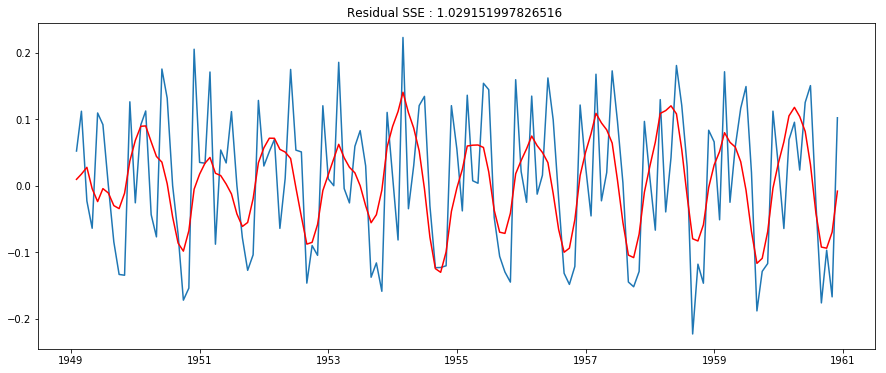

In [37]:
## AR(2) + MA(2) + 1 difference

arima_model_fitting(log_air_passengers, pdq = (2, 1, 2), **{'D1': True})

### Observation:
1. As per the above experiments, we can clearly see that pdq = (2, 1, 2) has the lowest SSE.
2. Difference 2 data has the highest SSE so , we will not use that for now,

In [38]:
## AR(2) + MA(2) + 1 difference
fitted_value = arima_model_fitting(log_air_passengers, pdq = (2, 1, 2), plotting=False, kwargs={'D1': True})

pred_AR2MA2_diff1 = pd.Series(fitted_value, copy=True)
print(pred_AR2MA2_diff1.head())

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [39]:
pred_AR2MA2_diff1_cumsum = pred_AR2MA2_diff1.cumsum()
print(pred_AR2MA2_diff1_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [40]:
# the entry in the log data are also 
# based on the index, so we will have to call it
# with the column name to get the value.
first_entry = log_air_passengers.iloc[0]
print(first_entry)
print(first_entry['Passengers'])

Passengers    4.718499
Name: 1949-01-01 00:00:00, dtype: float64
4.718498871295094


In [41]:
# get the index and first value in the series from the log data
# and then it will be added using the predicted cumsum()
pred_ARIMA_log = pd.Series(first_entry['Passengers'], index=log_air_passengers.index)
pred_ARIMA_log = pred_ARIMA_log.add(pred_AR2MA2_diff1_cumsum, fill_value=0)

pred_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

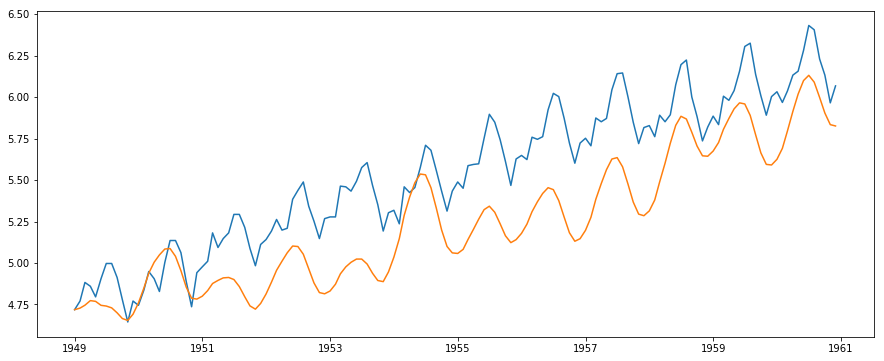

In [42]:
# plot log air data and predicted data
plt.plot(log_air_passengers)
plt.plot(pred_ARIMA_log)

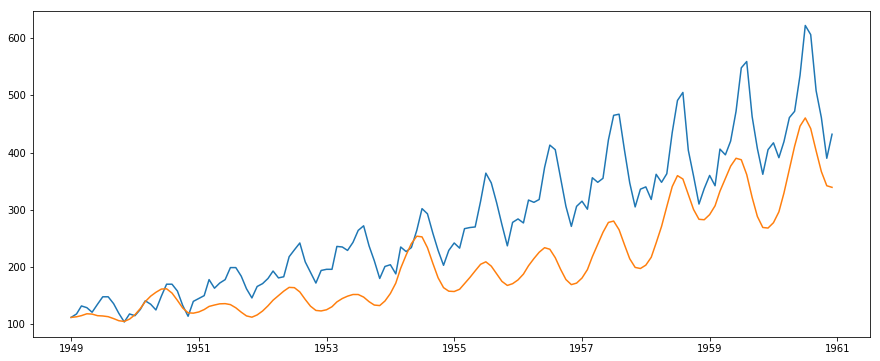

In [43]:
# plot air data and predicted data
pred_ARIMA = np.exp(pred_ARIMA_log)
plt.plot(air_passengers)
plt.plot(pred_ARIMA)

## Observation:
1. The result doesnot look promising so we will try some advance approach like SARIMA and will use the statsmodel api.

# Another approach for better forecasting

In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns


pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [45]:
passenger_data = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], infer_datetime_format=True,
                             names = ['Month', 'Passengers'], index_col = 0)

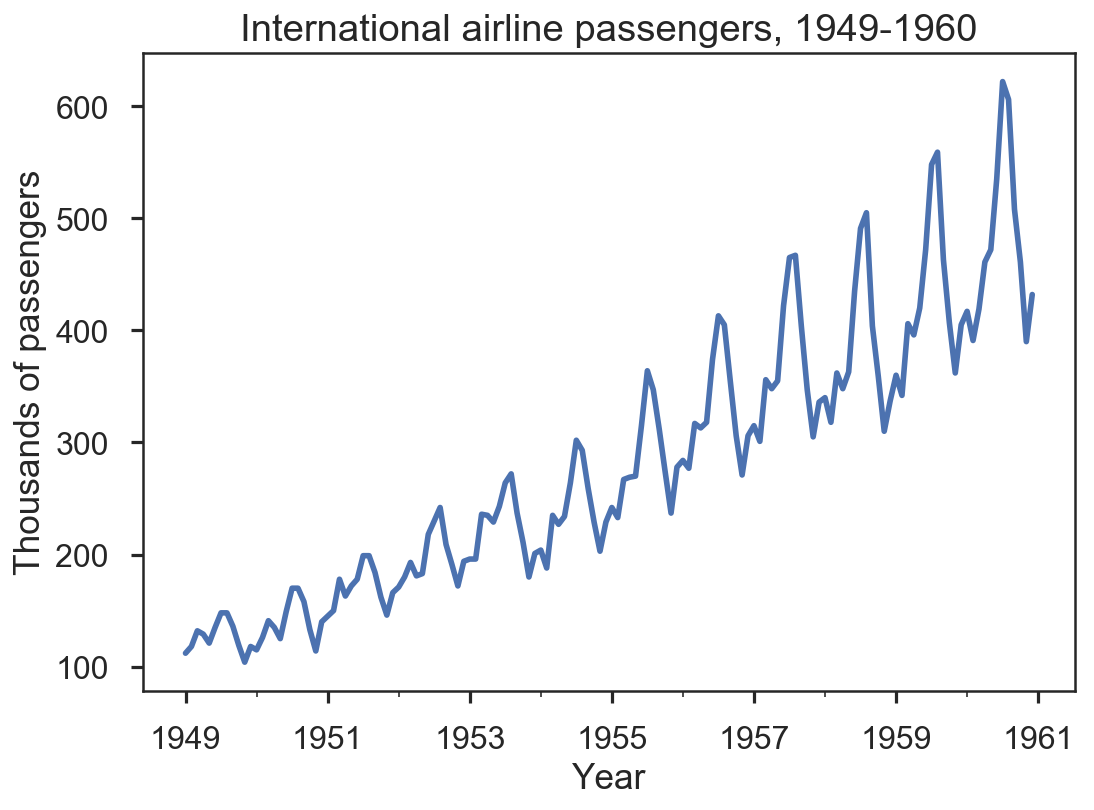

In [48]:
fig, ax = plt.subplots(figsize=(8,6));

passenger_data['Passengers'].plot(ax=ax);

ax.set_title(' Airline passengers, 1949-1960');
ax.set_ylabel('Thousands of passengers');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

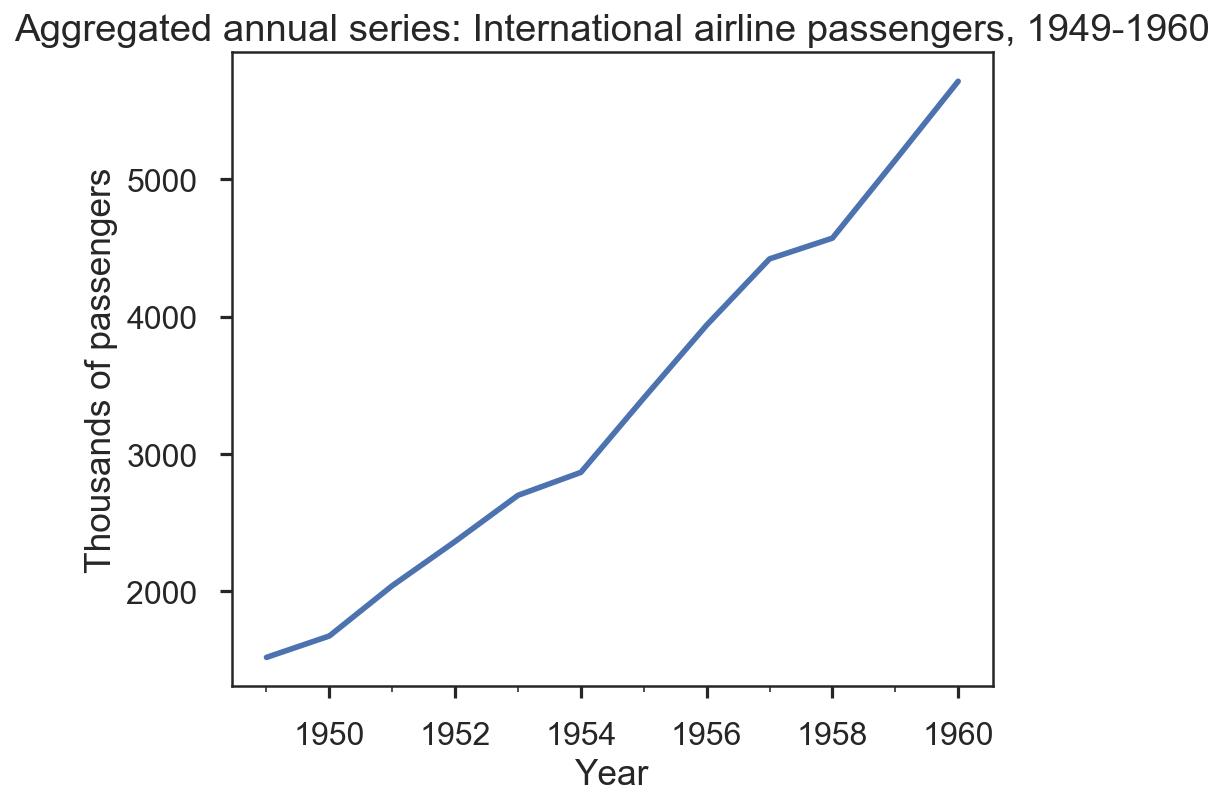

In [50]:
# Examine annual trend in the data
fig, ax = plt.subplots(figsize=(8,6));

passenger_data['Passengers'].resample('AS').sum().plot(ax=ax)

ax.set_title('Aggregated annual series: International airline passengers, 1949-1960');
ax.set_ylabel('Thousands of passengers');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();
fig.subplots_adjust(top=0.9)

In [62]:
# Examine seasonal trend in the data
passenger_data['Month'] = passenger_data.index.strftime('%b')
passenger_data['Year'] = passenger_data.index.year

monthly_pivot = passenger_data.pivot(index='Year', columns='Month', values='Passengers')

passenger_data = passenger_data.drop(['Month', 'Year'], axis=1)

# # put the months in order
ordered_months = pd.date_range(start='2016-01-01', periods=12, freq='MS').strftime('%b')
monthly_pivot = monthly_pivot.reindex(columns=ordered_months)

In [63]:
monthly_pivot

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1949,112,118,132,129,121,135,148,148,136,119,104,118
1950,115,126,141,135,125,149,170,170,158,133,114,140
1951,145,150,178,163,172,178,199,199,184,162,146,166
1952,171,180,193,181,183,218,230,242,209,191,172,194
1953,196,196,236,235,229,243,264,272,237,211,180,201
1954,204,188,235,227,234,264,302,293,259,229,203,229
1955,242,233,267,269,270,315,364,347,312,274,237,278
1956,284,277,317,313,318,374,413,405,355,306,271,306
1957,315,301,356,348,355,422,465,467,404,347,305,336


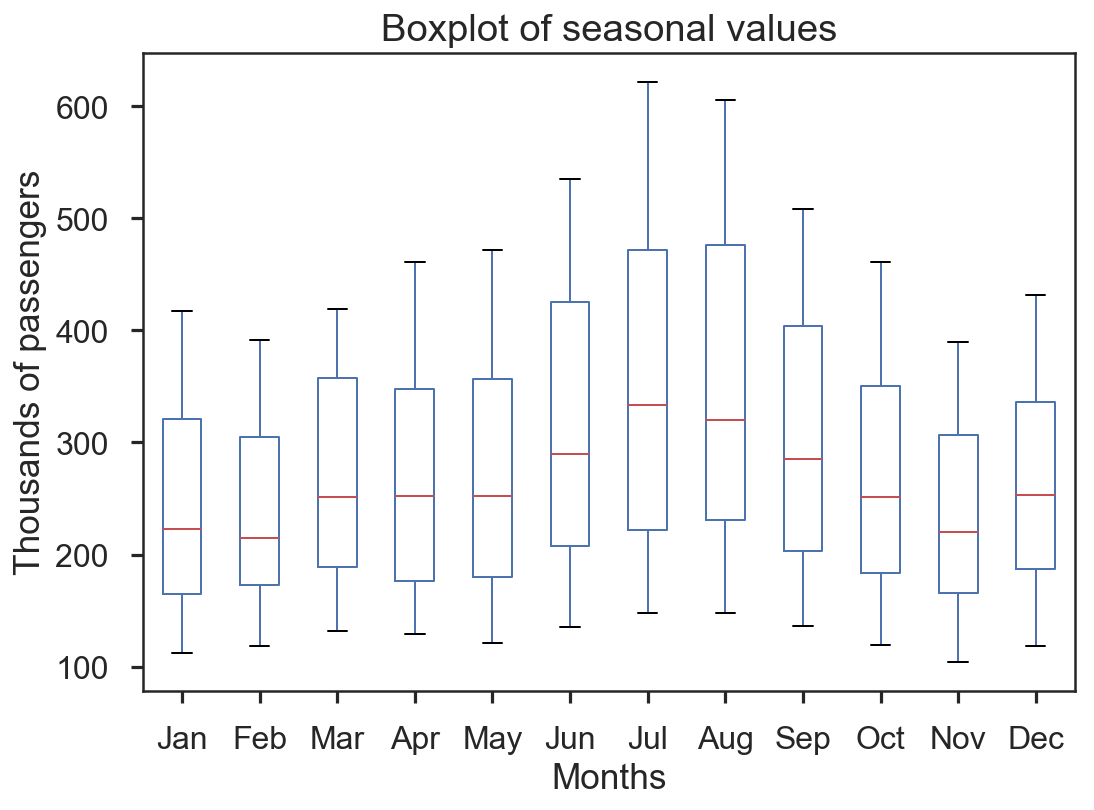

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))
monthly_pivot.plot(ax=ax, kind='box');

ax.set_xlabel('Months');
ax.set_ylabel('Thousands of passengers');
ax.set_title('Boxplot of seasonal values');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

In [65]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x1148a2ac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11496d048>)

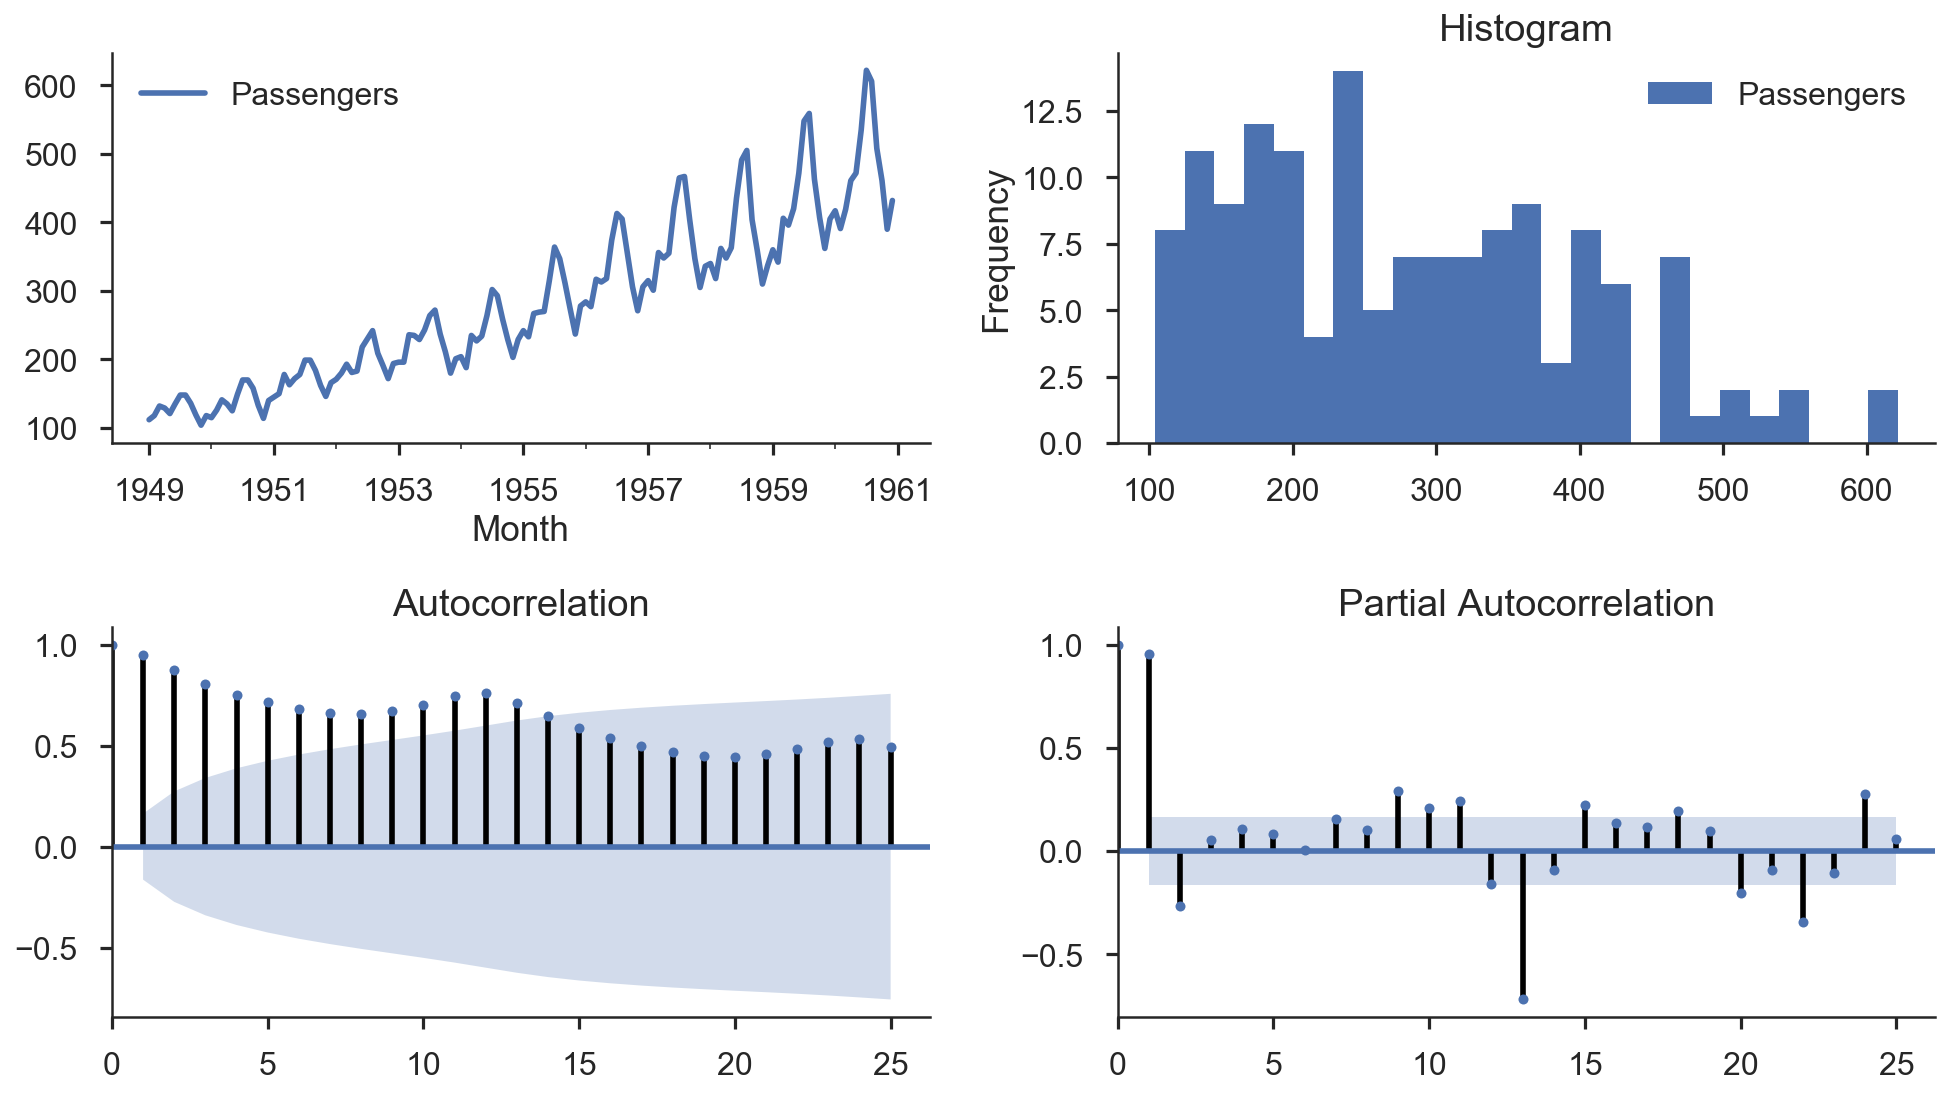

In [66]:
tsplot(passenger_data, lags=25)

(<matplotlib.axes._subplots.AxesSubplot at 0x1c1ad91e48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1147e3e48>)

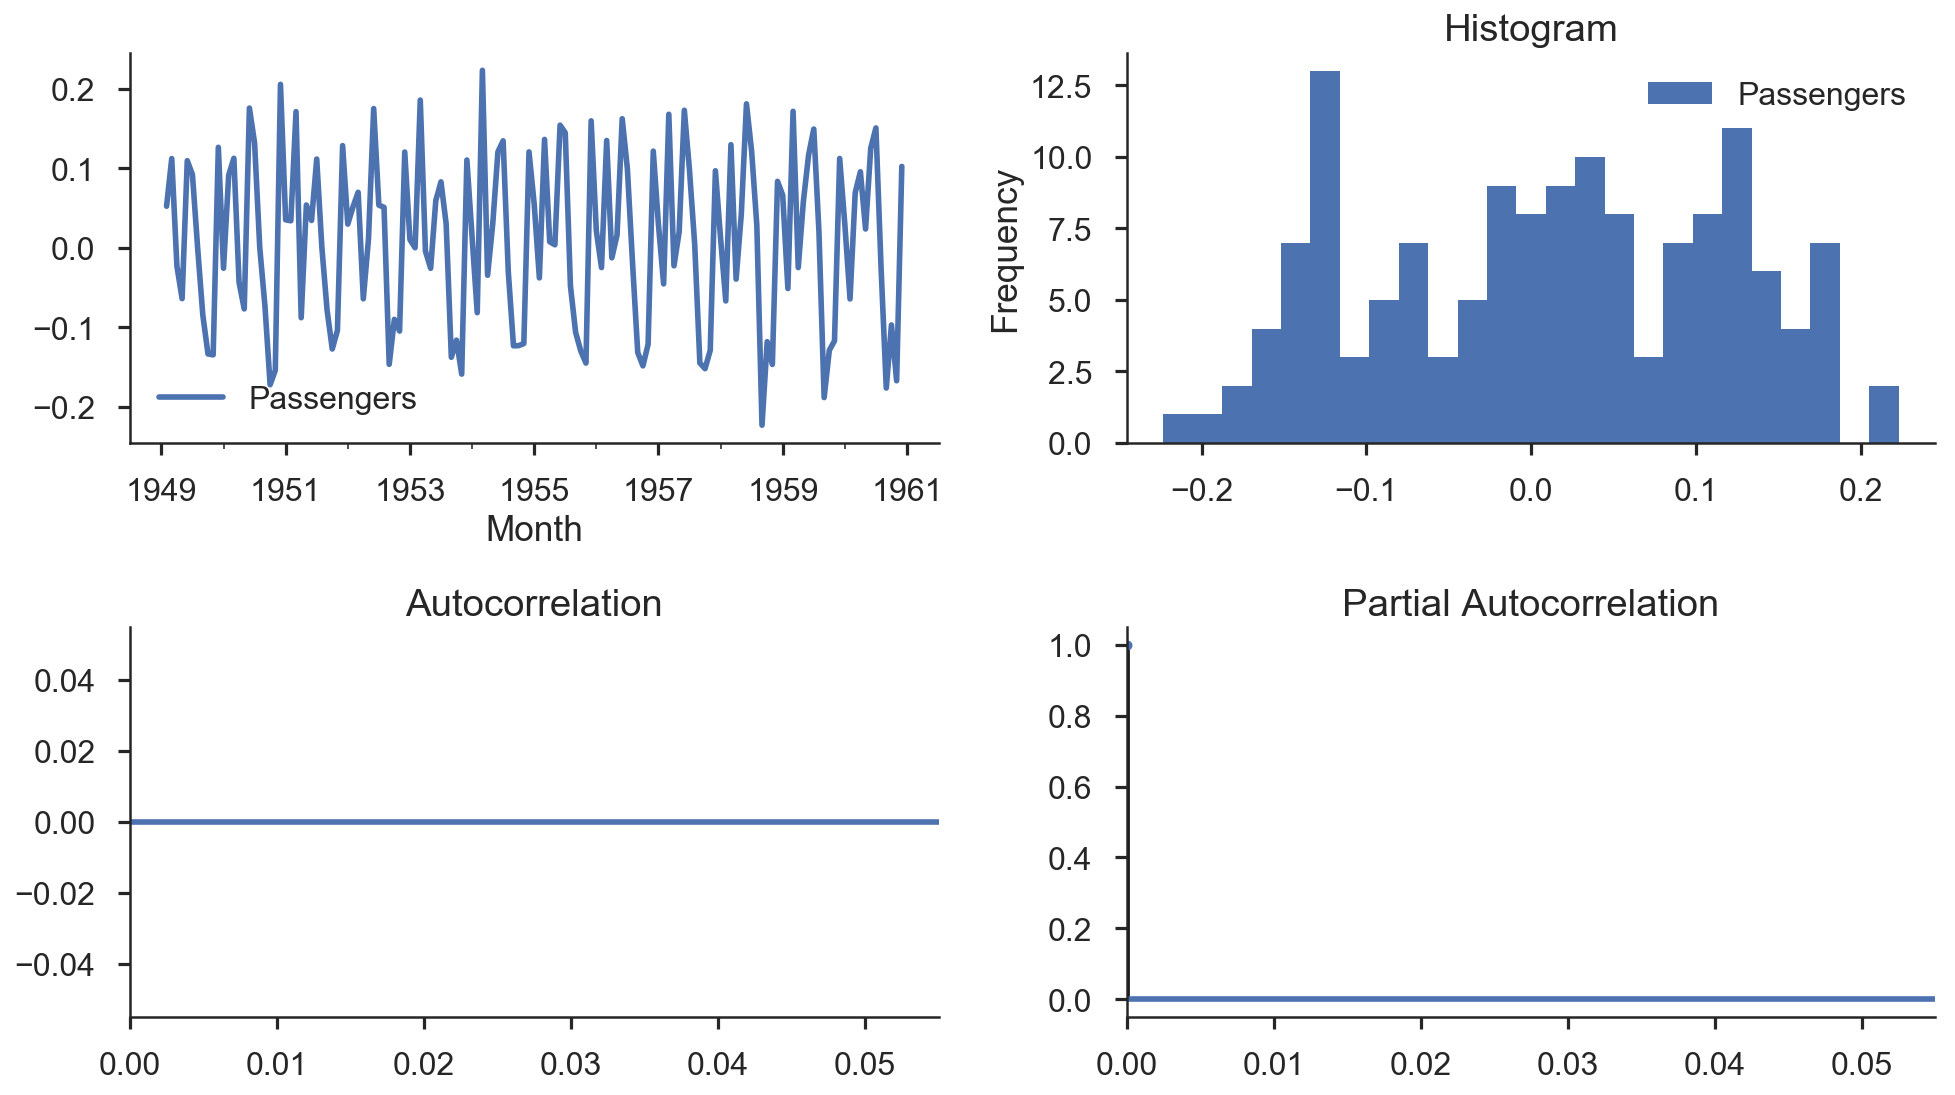

In [68]:
passenger_data_log = np.log(passenger_data)
diff1_log_air_data = passenger_data_log - passenger_data_log.shift()
tsplot(diff1_log_air_data, lags=25)

In [69]:
# SARIMA models
arima200 = smt.SARIMAX(diff1_log_air_data, order=(2,0,0))
model_results = arima200.fit()
model_results.summary()

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 122.261
Date:                Mon, 03 Sep 2018   AIC                           -238.522
Time:                        19:17:32   BIC                           -229.612
Sample:                    01-01-1949   HQIC                          -234.902
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2414      0.101      2.381      0.017       0.043       0.440
ar.L2         -0.1667      0.100     -1.665      0.096      -0.363       0.030
sigma2         0.0106      0.002      6.020      0.000       0.007       0.014
===================================================================================
Ljung-Box (Q):                      380.58   Jarque-Bera (JB):                 6.47
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               1.20   Skew:                             0.14
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

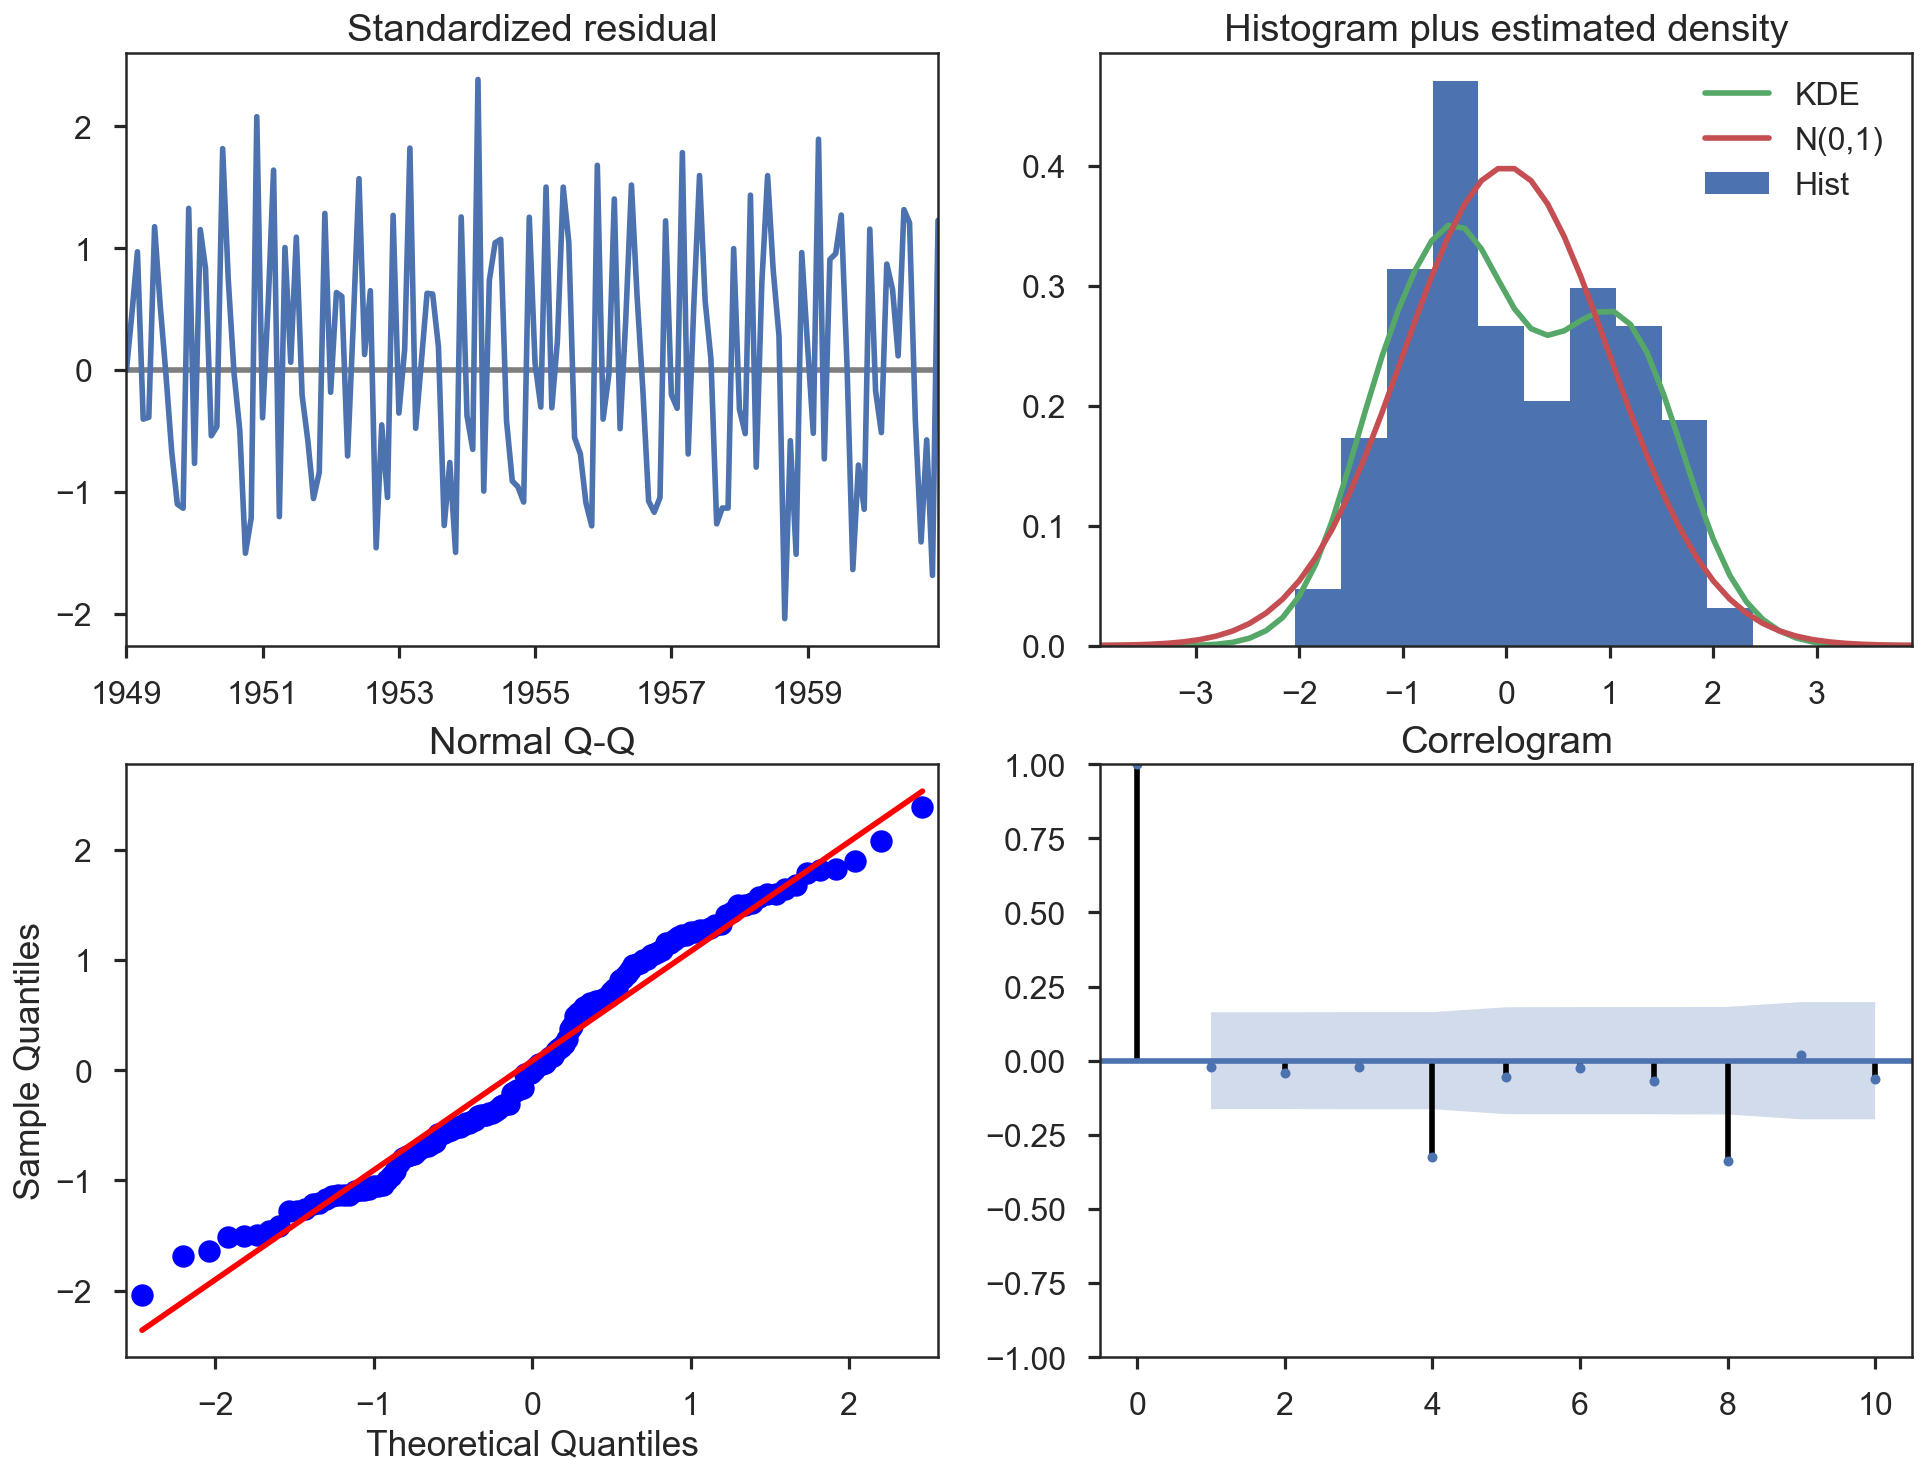

In [70]:
model_results.plot_diagnostics(figsize=(16, 12))

In [79]:
# SARIMA models
sarima202 = sm.tsa.SARIMAX(diff1_log_air_data, order=(2,0,0), seasonal_order=(1,1,1,12))
model_results = sarima202.fit()
model_results.summary()

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(1, 1, 1, 12)   Log Likelihood                 236.386
Date:                            Mon, 03 Sep 2018   AIC                           -462.771
Time:                                    19:29:53   BIC                           -448.357
Sample:                                01-01-1949   HQIC                          -456.914
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3729      0.079     -4.734      0.000      -0.527      -0.219
ar.L2         -0.0740      0.098     -0.753      0.451      -0.266       0.118
ar.S.L12      -0.0993      0.184     -0.541      0.589      -0.459       0.260
ma.S.L12      -0.4946      0.205     -2.411      0.016      -0.897      -0.092
sigma2         0.0014      0.000      8.673      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       41.85   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.39   Prob(JB):                         0.51
Heteroskedasticity (H):               0.58   Skew:                             0.05
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

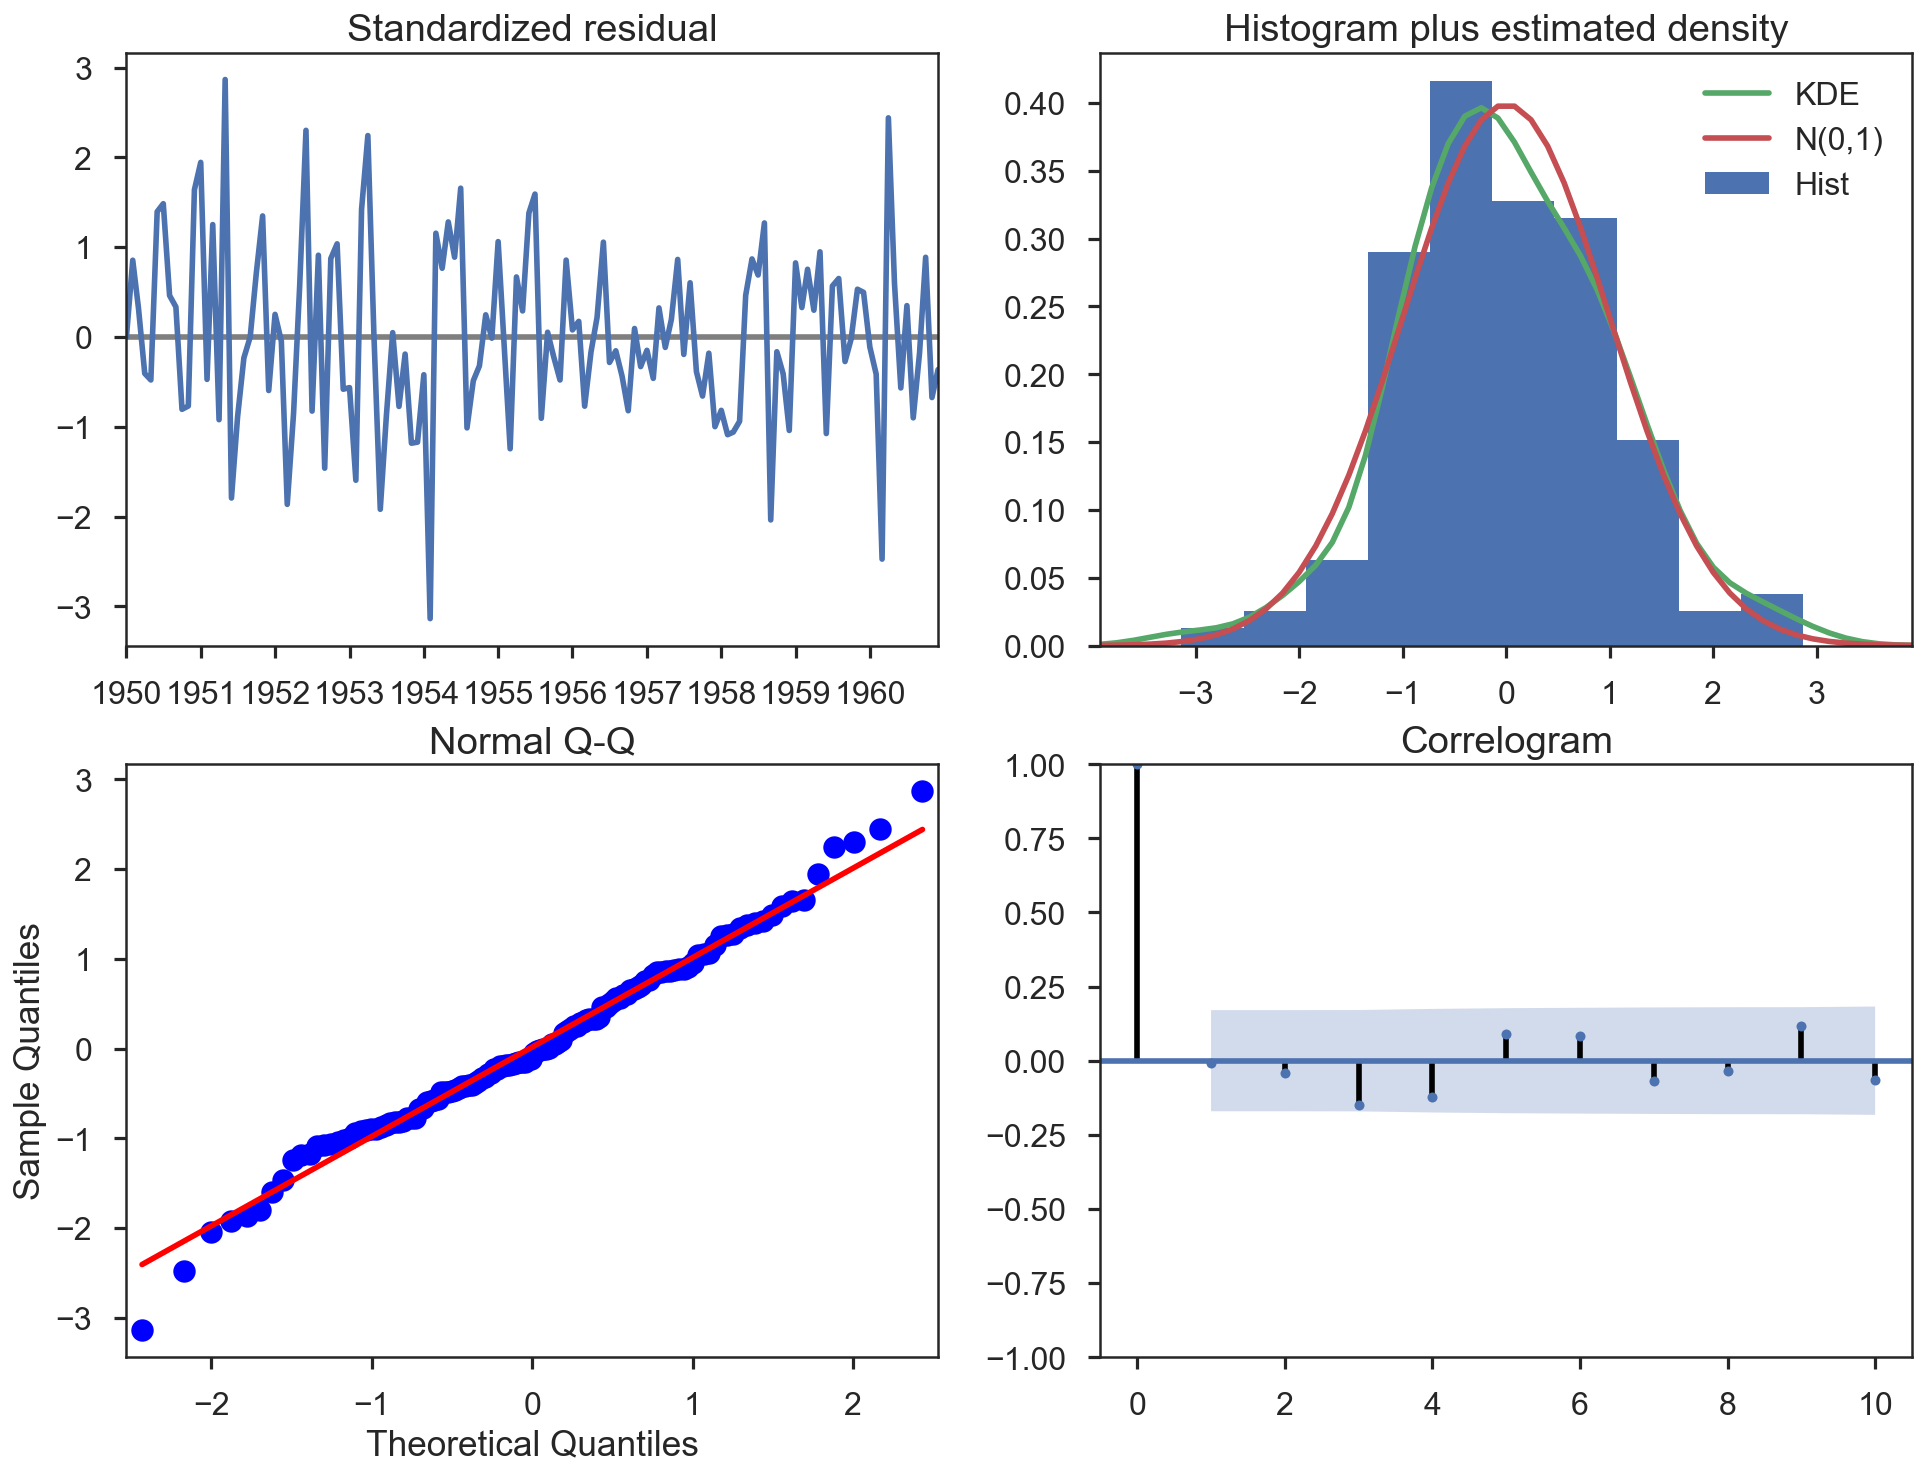

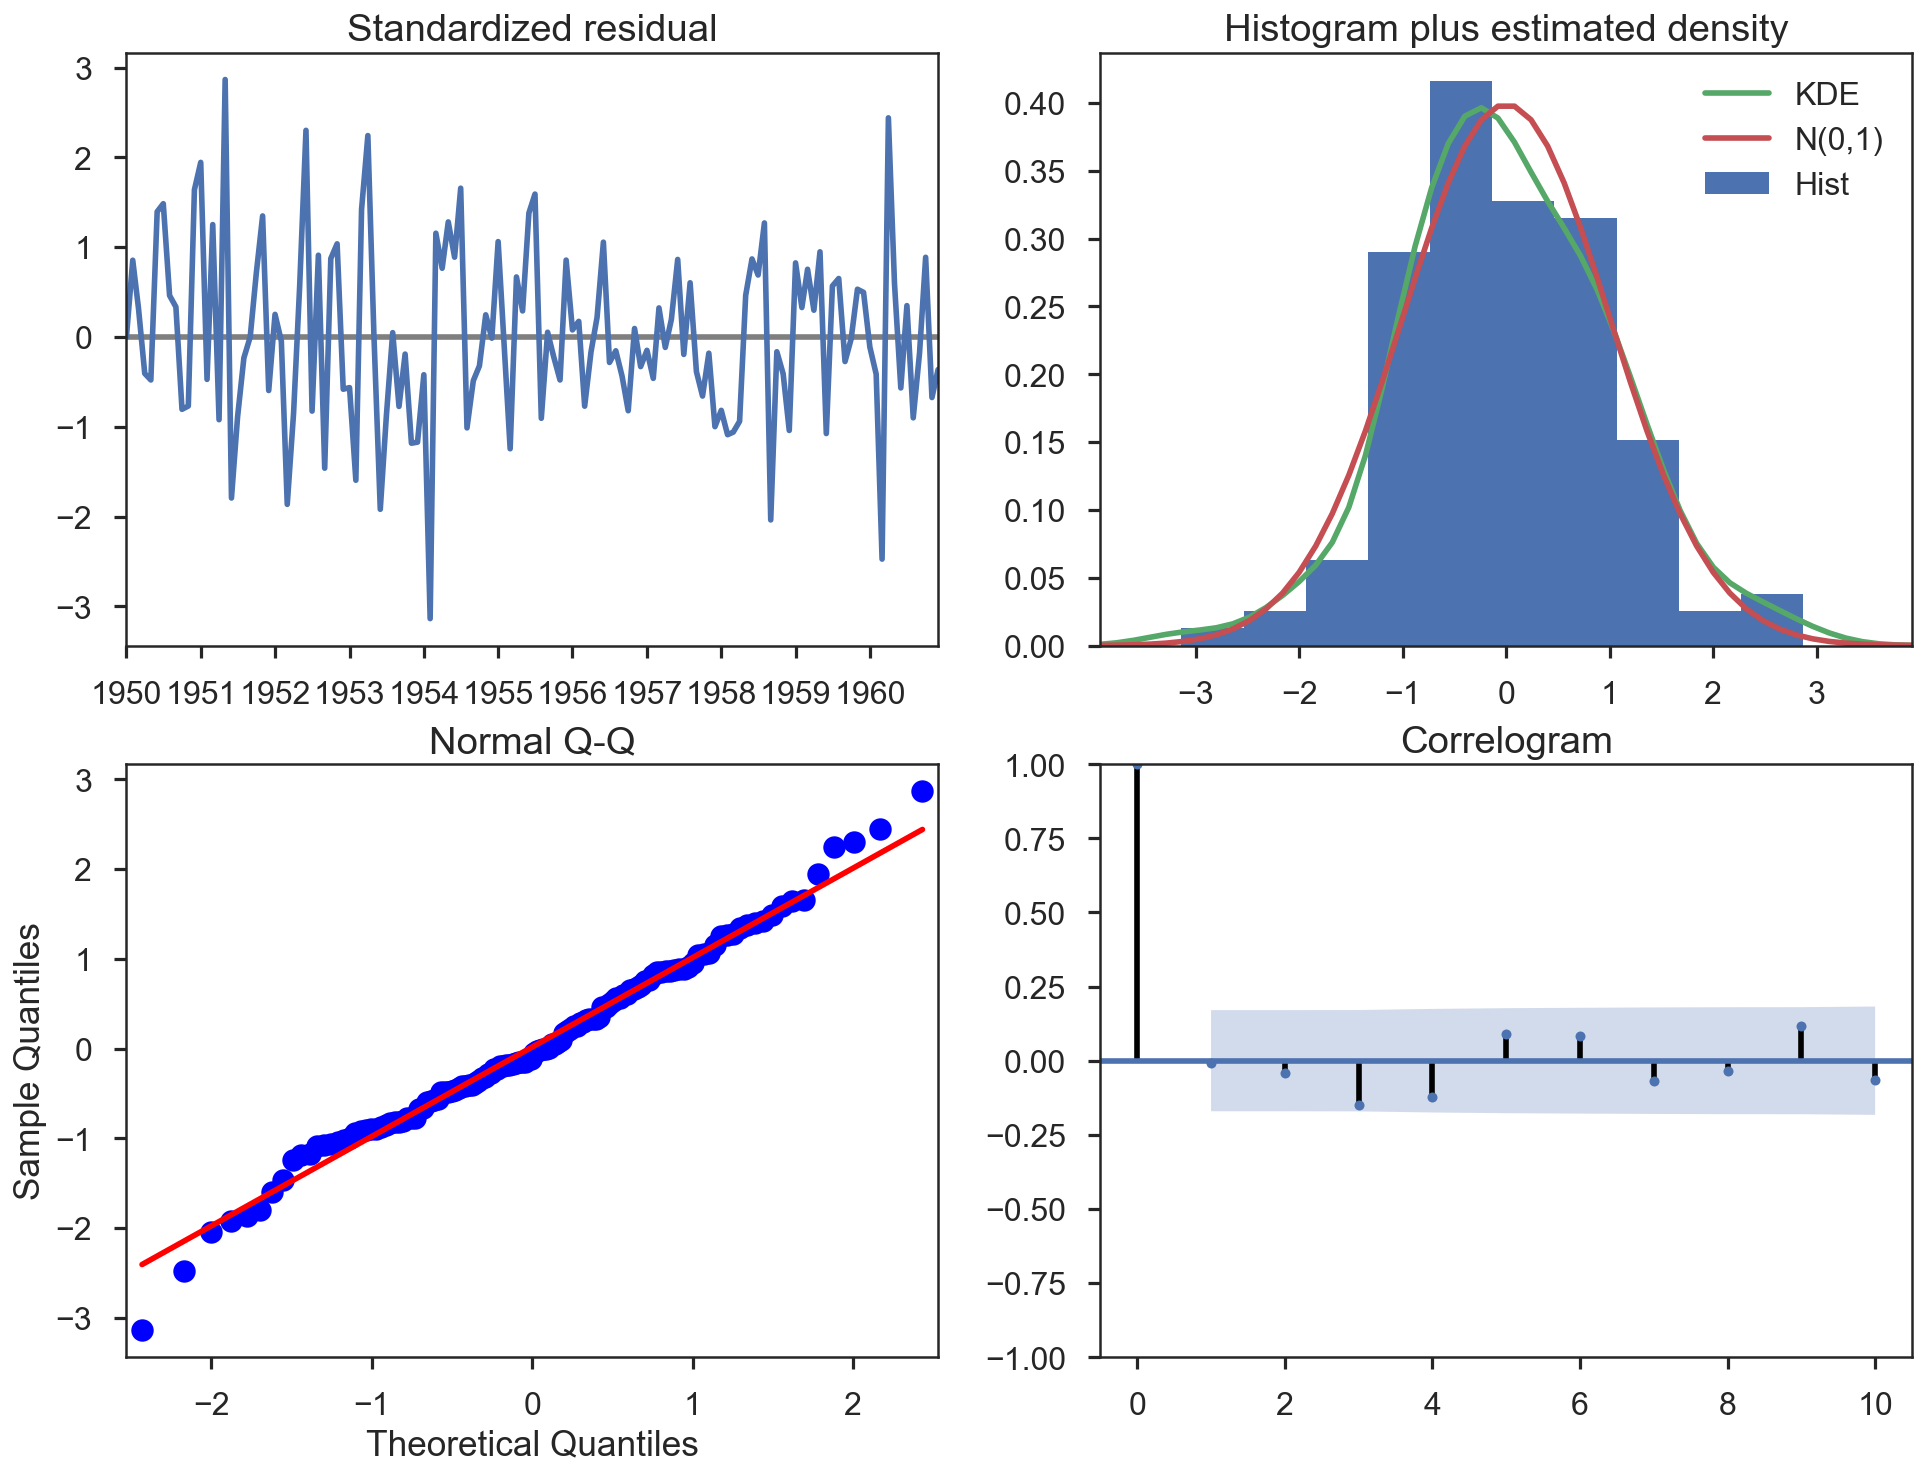

In [80]:
model_results.plot_diagnostics(figsize=(16, 12))

In [77]:
# sarima202_pred = model_results.fittedvalues()
# sarima202_pred = pd.Series(fitted_value, copy=True)
# sarima202_pred
model_results